# Importo tutte le librerie necessarie

In [71]:
import clip
import random
import math
from PIL import Image
import pickle
import numpy as np
from pathlib import Path
from sklearn.svm import SVC
from sklearn.metrics import precision_score, f1_score, recall_score, classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import traceback
import subprocess
from shutil import copyfile
import torch.nn.functional as F
try:
    subprocess.run(["nvidia-smi"], check=True)
except subprocess.CalledProcessError as e:
    print("Errore nvidia-smi:", e)

from IPython.display import display, HTML
import pandas as pd
from tqdm import tqdm
from sklearn.manifold import TSNE
import gc
from sklearn.model_selection import train_test_split
from scripts.pre_processing import metadata_list
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os

# Definizione della funzione Early_stopping che permette di ottimizzare i parametri per dare il pieno controllo su quando e come l'addestramento si interrompe
Questa funzione fa in modo che l'addestramento si blocca prematuramente quando il modello smette di migliorare. Inoltre:
1) Evita overfitting interrompendo quando la loss non migliora per patience epoche
2) Salva checkpoint con backup ridondante
3) Supporta diverse metriche di monitoraggio (loss/accuracy)
4) Gestisce casi limite con sistema di recovery

In [72]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', monitor='val_loss', mode='min'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.path = path
        self.backup_path = "backup_checkpoint.pt"  # Backup integrato
        self.monitor = monitor
        self.mode = mode

        if self.mode == 'min':
            self.best_score = np.Inf
        else:
            self.best_score = -np.Inf

    def __call__(self, current_metric_value, model=None):
        if self.mode == 'min':
            if current_metric_value < self.best_score - self.delta:
                self.save_checkpoint(current_metric_value, model)
                self.best_score = current_metric_value
                self.counter = 0
            else:
                self.counter += 1
        else:
            if current_metric_value > self.best_score + self.delta:
                self.save_checkpoint(current_metric_value, model)
                self.best_score = current_metric_value
                self.counter = 0
            else:
                self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True

    def save_checkpoint(self, val_metric_value, model=None):
        try:
            # Crea backup se esiste già un checkpoint
            if Path(self.path).exists():
                copyfile(self.path, self.backup_path)

            # Salva nuovo checkpoint
            torch.save({
                'model_state_dict': model.state_dict(),
                'val_metric': val_metric_value
            }, self.path)

            if self.verbose:
                print(f"Checkpoint salvato in {self.path}")
        except Exception as e:
            print(f"[CRITICO] Errore salvataggio: {str(e)}")
            print(f"Tentativo di ripristino backup {self.backup_path}")
            if Path(self.backup_path).exists():
                copyfile(self.backup_path, self.path)

# Controlli iniziali sulla GPU da eseguire prima di qualsiasi operazione

In [73]:
display(HTML("<style>.output_wrapper .output { max-height: 10000px; }</style>"))

# Imposta il limite di dati subito dopo
%config ServerApp.iopub_data_rate_limit=1000000000  # 1GB/sec
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%config Completer.use_jedi = False

# PRIMA di chiamare generate_and_save_embeddings, pulisco la memoria:
gc.collect()
torch.cuda.empty_cache()

# Eseguo la generazione degli embedding con batch size ridotto:
print("\n[INFO] Inizio generazione embedding con controllo memoria...")
!nvidia-smi  # Check iniziale GPU

# Dopo l'operazione, pulisci di nuovo e verifica
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi  # Check finale GPU

# Funzione di utilità per monitoraggio GPU
def print_gpu_utilization():
    if torch.cuda.is_available():
        print(f"[GPU] Memoria allocata: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
        print(f"[GPU] Memoria riservata: {torch.cuda.memory_reserved()/1024**2:.2f} MB")
    else:
        print("[GPU] CUDA non disponibile")


os.system("nvidia-smi # ...")  # Cerca comandi con caratteri speciali


[INFO] Inizio generazione embedding con controllo memoria...
ERROR: Option # is not recognized. Please run 'nvidia-smi -h'.

ERROR: Option # is not recognized. Please run 'nvidia-smi -h'.



255

# Utilizzo cuda al posto della cpu per velocizzare il processo

In [74]:
# === Configurazione dispositivo ===
device = "cuda" if torch.cuda.is_available() else "cpu"
print("[INFO] Dispositivo in uso:", device)
if device == "cuda":
    print("CUDA disponibile:", torch.cuda.is_available())
    print("Nome GPU:", torch.cuda.get_device_name(0))
    print_gpu_utilization()

[INFO] Dispositivo in uso: cuda
CUDA disponibile: True
Nome GPU: NVIDIA GeForce GTX 1050 Ti
[GPU] Memoria allocata: 361.98 MB
[GPU] Memoria riservata: 656.00 MB


# Importo i dataset cycle_gan e pro_gan poichè presentano un numero di immagini Real e Fake bilanciato

In [75]:
def get_datasets(metadata_list, indices):
    # Se indices è un singolo intero, lo convertiamo in una lista
    if isinstance(indices, int):
        indices = [indices]

    result = []
    for index in indices:
        if index < 0 or index >= len(metadata_list):
            raise IndexError(f"L'indice specificato {index} non è valido")
        result.append(metadata_list[index])
    return result

# Esempio di utilizzo per selezionare CycleGAN (5) e Pro-GAN (24)
try:
    datasets = get_datasets(metadata_list, [5, 24])
    print("[INFO] Dataset Cycle-GAN e Pro-GAN:")
    for i, dataset in zip([5, 24], datasets):
        print(f"Dataset all'indice {i}:")
        print(dataset)
except IndexError as e:
    print(f"[ERRORE] {e}")

[INFO] Dataset Cycle-GAN e Pro-GAN:
Dataset all'indice 5:
            filename                    image_path  target     category
0      img000851.jpg  st/horse2zebra/img000851.jpg       0  horse2zebra
1      img004163.jpg  st/horse2zebra/img004163.jpg       0  horse2zebra
2      img003305.jpg  st/horse2zebra/img003305.jpg       0  horse2zebra
3      img001548.jpg  st/horse2zebra/img001548.jpg       1  horse2zebra
4      img004940.jpg  st/horse2zebra/img004940.jpg       1  horse2zebra
...              ...                           ...     ...          ...
15205  img016350.jpg  st/photo2monet/img016350.jpg       0  photo2monet
15206  img011734.jpg  st/photo2monet/img011734.jpg       0  photo2monet
15207  img015011.jpg  st/photo2monet/img015011.jpg       0  photo2monet
15208  img014558.jpg  st/photo2monet/img014558.jpg       1  photo2monet
15209  img015042.jpg  st/photo2monet/img015042.jpg       0  photo2monet

[15210 rows x 4 columns]
Dataset all'indice 24:
            filename         

# Caricamento del modello CLIP e creazione di un metodo che permette di estrarre singolarmente le singole immagini dai dataset Cycle-GAN e Pro-Gan, convertendole in vettori di embedding di dimensione 512. Questo passaggio è fondamentale poichè il modello CLIP non è in grado di lavorare direttamente sulle immagini.

In [76]:
# Definisci i percorsi base per i dataset
CYCLEGAN_PATH = Path("..") / "dataset" / "cycle_gan"
PROGAN_PATH = Path("..") / "dataset" / "pro_gan"

# Prepara la lista dei dataset con i loro percorsi
# CORREZIONE: Usa le variabili esistenti datasets[0] e datasets[1]
datasets_info = [
    (datasets[0], CYCLEGAN_PATH),  # CycleGAN (primo elemento della lista)
    (datasets[1], PROGAN_PATH)     # Pro-GAN (secondo elemento della lista)
]

def generate_and_save_embeddings(image_paths, clip_model, datasets_info, device="cuda"):
    path_to_target = {}
    path_to_source = {}  # Aggiunto per memorizzare la sorgente

    total_paths = 0
    missing_paths = 0

    for dataset_df, base_path in datasets_info:
        base_path = Path(base_path).resolve()

        for _, row in dataset_df.iterrows():
            img_abs_path = (base_path / row['image_path']).resolve()
            normalized_path = str(img_abs_path).lower().replace("\\", "/")
            total_paths += 1

            if not img_abs_path.exists():
                missing_paths += 1
                continue

            if normalized_path not in path_to_target:
                path_to_target[normalized_path] = row['target']

                # Determina sorgente dal percorso
                if "cycle_gan" in normalized_path:
                    source = "cycle_gan"
                elif "pro_gan" in normalized_path:
                    source = "pro_gan"
                else:
                    source = "unknown"
                path_to_source[normalized_path] = source

    if missing_paths > 0:
        print(f"[WARNING] {missing_paths}/{total_paths} percorsi immagine non trovati")

    # 2. Preparazione modello CLIP
    _, clip_preprocess = clip.load("ViT-B/32", device=device)
    embeddings = []
    labels = []
    sources = []

    # 3. Processa ogni immagine
    for img_path in tqdm(image_paths, desc="Generazione embedding"):
        try:
            # Normalizza percorso per matching
            abs_path = Path(img_path).resolve()
            abs_normalized = str(abs_path).lower().replace("\\", "/")

            # Verifica esistenza file
            if not abs_path.exists():
                print(f"[WARNING] File non trovato: {abs_normalized}")
                continue

            # Cerca target nel dizionario
            if abs_normalized not in path_to_target:
                print(f"[WARNING] Percorso {abs_normalized} non presente nel dizionario di target")
                continue

            target = path_to_target[abs_normalized]
            source = path_to_source[abs_normalized]

            # Carica e preprocessa immagine
            image = Image.open(img_path).convert("RGB")
            image_tensor = clip_preprocess(image).unsqueeze(0).to(device)

            # Genera embedding
            with torch.no_grad():
                embedding = clip_model.encode_image(image_tensor).cpu().numpy()[0]

            embeddings.append(embedding)
            labels.append(target)
            sources.append(source)

        except Exception as e:
            print(f"Errore su {img_path}: {str(e)}")
            continue

    if len(embeddings) == 0:
        raise ValueError("Nessun embedding generato. Verifica i percorsi")

    return np.array(embeddings), np.array(labels), np.array(sources)

# Funzione che verifica se i vettori di embedding per le immagini del dataset Cycle-GAN e Pro-GAN sono stati generati correttamente

In [77]:
def verifica_embedding_clip_multiple(model, preprocess, embeddings_dict, datasets_info, device="cuda"):
    # Costruisci dizionario path-target per tutti i dataset
    path_to_target = {}
    for dataset_df, base_path in datasets_info:
        base_path = Path(base_path).resolve()
        for _, row in dataset_df.iterrows():
            img_abs_path = (base_path / row['image_path']).resolve()
            normalized_path = str(img_abs_path).lower().replace("\\", "/")
            if normalized_path not in path_to_target:
                path_to_target[normalized_path] = row['target']

    # Prepara figura per visualizzazione
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    plt.suptitle("Verifica Embedding e Preprocessing", fontsize=16)

    for i, (dataset_df, base_path) in enumerate(datasets_info):
        # Seleziona un indice casuale valido per il dataset
        index = random.randint(0, len(dataset_df) - 1)
        row = dataset_df.iloc[index]

        # Costruisci percorso normalizzato
        base_path = Path(base_path).resolve()
        img_abs_path = (base_path / row['image_path']).resolve()
        normalized_path = str(img_abs_path).lower().replace("\\", "/")

        # Recupera i dati dell'embedding usando il percorso normalizzato
        if normalized_path not in embeddings_dict:
            print(f"[WARNING] Embedding non trovato per {normalized_path}")
            # Mostra messaggio di errore
            axes[i*2].text(0.5, 0.5, f"Embedding non trovato\n{normalized_path}",
                          ha='center', va='center')
            axes[i*2].set_title(f"{base_path.name} - Errore")
            axes[i*2].axis('off')
            axes[i*2+1].axis('off')
            continue

        embedding_data = embeddings_dict[normalized_path]
        label = embedding_data['target']
        embedding = embedding_data['embedding']

        print(f"\n[INFO] Dataset: {base_path.name}")
        print(f"• Percorso immagine: {normalized_path}")
        print(f"• Etichetta: {label}")
        print(f"• Dimensione embedding: {embedding.shape}")
        print(f"• Primi valori embedding: {embedding[:5]}...")

        try:
            # Carica e processa l'immagine
            with Image.open(img_abs_path) as img:
                img.verify()
            original_img = Image.open(img_abs_path).convert("RGB")

            # Preprocess con CLIP
            processed_tensor = preprocess(original_img).unsqueeze(0).to(device)
            processed_tensor = processed_tensor.squeeze(0)

            # Denormalizza per visualizzazione
            try:
                # Tentativo di denormalizzazione (se disponibile)
                denorm_img = denormalize_clip_image(processed_tensor).permute(1, 2, 0).cpu().numpy()
                denorm_img = np.clip(denorm_img, 0, 1)
            except:
                # Fallback se la funzione non è disponibile
                denorm_img = processed_tensor.permute(1, 2, 0).cpu().numpy()
                denorm_img = np.clip(denorm_img, 0, 1)

            # Visualizzazione
            axes[i*2].imshow(original_img)
            axes[i*2].set_title(f"{base_path.name}\nOriginale: {img_abs_path.name}")
            axes[i*2].axis('off')

            axes[i*2+1].imshow(denorm_img)
            axes[i*2+1].set_title(f"{base_path.name}\nPreprocessata (224x224)")
            axes[i*2+1].axis('off')

        except Exception as e:
            print(f"[ERRORE] Elaborazione immagine fallita per {img_abs_path}: {str(e)}")
            # Mostra placeholder in caso di errore
            axes[i*2].text(0.5, 0.5, f"Errore\n{str(e)}", ha='center', va='center')
            axes[i*2].set_title(f"{base_path.name} - Errore")
            axes[i*2].axis('off')
            axes[i*2+1].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# Funzione che si occupa della generazione delle triplette per i vettori di embeddings

In [78]:
def generate_triplets_fixed_batch(embeddings, labels, sources, batch_size=128, n_triplets=10000):
    """Genera batch di triplette per l'addestramento con gestione avanzata degli errori"""
    # 1. Prepara i dati con conversione e normalizzazione
    n = len(embeddings)
    if n < 2:
        raise ValueError("Il dataset deve contenere almeno 2 campioni")

    # Mappa etichette numeriche a stringhe
    label_map = {0: 'real', 1: 'fake'}
    if isinstance(labels[0], (int, np.integer)):
        labels_str = np.array([label_map.get(label, 'unknown') for label in labels])
    else:
        labels_str = np.array(labels)

    # Normalizza i nomi delle sorgenti
    sources_norm = []
    for s in sources:
        s_lower = str(s).lower()
        if 'cycle' in s_lower:
            sources_norm.append('cycle_gan')
        elif 'pro' in s_lower or 'progan' in s_lower:
            sources_norm.append('pro_gan')
        else:
            sources_norm.append('unknown')
    sources_norm = np.array(sources_norm)

    # 2. Debug: analisi distribuzione dati
    print("\n[DEBUG] Distribuzione dati per generazione triplette:")
    print(f"- Totale esempi: {n}")
    print(f"- Classi uniche: {np.unique(labels_str)}")
    print(f"- Sorgenti uniche: {np.unique(sources_norm)}")

    for label in ['real', 'fake']:
        for source in ['cycle_gan', 'pro_gan']:
            mask = (sources_norm == source) & (labels_str == label)
            count = np.sum(mask)
            print(f"  {label}/{source}: {count} esempi")

    # 3. Costruisci struttura per accesso efficiente
    class_dataset_indices = {
        'real': {'cycle_gan': [], 'pro_gan': []},
        'fake': {'cycle_gan': [], 'pro_gan': []}
    }

    for idx, (label, source) in enumerate(zip(labels_str, sources_norm)):
        if source in ['cycle_gan', 'pro_gan'] and label in ['real', 'fake']:
            class_dataset_indices[label][source].append(idx)

    # 4. Identifica classi valide con almeno 2 campioni
    valid_classes = []
    for label in ['real', 'fake']:
        for source in ['cycle_gan', 'pro_gan']:
            if len(class_dataset_indices[label][source]) >= 2:
                valid_classes.append((label, source))

    if not valid_classes:
        raise ValueError("Nessuna combinazione classe-dataset valida con almeno 2 esempi")
    print(f"Combinazioni valide per triplette: {valid_classes}")

    # 5. Generazione triplette con gestione errori avanzata
    triplet_batches = []
    current_batch = []
    count = 0
    error_count = 0
    max_errors = min(500, n_triplets // 2)  # Limite errori basato su n_triplets

    # Contatori per debugging
    stats = {
        'same_source': 0,
        'cross_source': 0,
        'any_source': 0
    }

    pbar = tqdm(total=n_triplets, desc="Generazione triplette")
    while count < n_triplets:
        try:
            # Seleziona casualmente una combinazione valida
            class_label, source = random.choice(valid_classes)

            # Recupera indici per anchor e positive
            indices = class_dataset_indices[class_label][source]
            if len(indices) < 2:
                error_count += 1
                continue

            anchor_idx, positive_idx = random.sample(indices, 2)

            # Identifica classe opposta
            opposite_label = 'fake' if class_label == 'real' else 'real'

            # Strategia per trovare negative (priorità 1: stessa sorgente)
            negative_indices = class_dataset_indices[opposite_label][source]
            source_type = 'same_source'

            # Priorità 2: altra sorgente valida
            if not negative_indices:
                other_source = 'pro_gan' if source == 'cycle_gan' else 'cycle_gan'
                negative_indices = class_dataset_indices[opposite_label][other_source]
                source_type = 'cross_source'

            # Priorità 3: qualsiasi sorgente
            if not negative_indices:
                negative_indices = [i for i, (l, s) in enumerate(zip(labels_str, sources_norm))
                                  if l == opposite_label and s in ['cycle_gan', 'pro_gan']]
                source_type = 'any_source'

            # Priorità 4: qualsiasi esempio di classe opposta
            if not negative_indices:
                negative_indices = [i for i, l in enumerate(labels_str) if l == opposite_label]
                source_type = 'fallback'

            if not negative_indices:
                error_count += 1
                if error_count % 50 == 0:
                    print(f"[WARNING] Nessun esempio negativo trovato per {opposite_label} (errori: {error_count})")
                continue

            negative_idx = random.choice(negative_indices)
            stats[source_type] = stats.get(source_type, 0) + 1

            # Aggiungi tripletta al batch
            triplet = (
                embeddings[anchor_idx],
                embeddings[positive_idx],
                embeddings[negative_idx]
            )
            current_batch.append(triplet)
            count += 1
            error_count = 0  # Reset error counter
            pbar.update(1)

            # Gestisci batch completo
            if len(current_batch) == batch_size:
                anchors = np.array([t[0] for t in current_batch])
                positives = np.array([t[1] for t in current_batch])
                negatives = np.array([t[2] for t in current_batch])

                triplet_batches.append((anchors, positives, negatives))
                current_batch = []

        except Exception as e:
            error_count += 1
            if error_count % 50 == 0:
                print(f"[WARNING] Errore generazione tripletta ({error_count}/{max_errors}): {str(e)}")

            if error_count > max_errors:
                print(f"[CRITICAL] Troppi errori consecutivi ({error_count}). Interruzione generazione.")
                break
            continue

    pbar.close()

    # Gestisci batch finale incompleto
    if current_batch:
        anchors = np.array([t[0] for t in current_batch])
        positives = np.array([t[1] for t in current_batch])
        negatives = np.array([t[2] for t in current_batch])
        triplet_batches.append((anchors, positives, negatives))

    # Report statistiche
    print("\n[STATS] Tipologie di triplette generate:")
    print(f"- Stessa sorgente: {stats.get('same_source', 0)}")
    print(f"- Sorgente incrociata: {stats.get('cross_source', 0)}")
    print(f"- Qualsiasi sorgente valida: {stats.get('any_source', 0)}")
    print(f"- Fallback: {stats.get('fallback', 0)}")
    print(f"Triplette totali generate: {count}/{n_triplets}")
    print(f"Batch creati: {len(triplet_batches)}")

    if count == 0:
        raise RuntimeError("Generazione triplette fallita: 0 triplette create")

    return triplet_batches

# Definisco una funzione chiamata Triplet Model che è una rete neurale che impara a proiettare gli embedding in uno spazio dove le distanze riflettono la similarità.

In [79]:
class TripletModel(nn.Module):
    def __init__(self, input_dim=512, embedding_dim=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim),
            nn.LayerNorm(embedding_dim)
        )

    def forward(self, x):
        return self.fc(x)

    def train_model(self, train_loader, val_loader, num_epochs=10, lr=1e-4, device="cuda"):
        """Addestra il modello con validazione periodica"""
        self.to(device)
        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = TripletLoss(margin=0.2, distance="euclidean")

        best_val_loss = float('inf')

        for epoch in range(num_epochs):
            # Fase di training
            self.train()
            train_loss = 0.0
            for anchor, positive, negative in train_loader:
                anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

                # Forward pass
                anchor_emb = self(anchor)
                positive_emb = self(positive)
                negative_emb = self(negative)

                # Calcola loss
                loss = criterion(anchor_emb, positive_emb, negative_emb)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            avg_train_loss = train_loss / len(train_loader)

            # Fase di validazione
            self.eval()
            val_loss = 0.0
            with torch.no_grad():
                for anchor, positive, negative in val_loader:
                    anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

                    anchor_emb = self(anchor)
                    positive_emb = self(positive)
                    negative_emb = self(negative)
                    loss = criterion(anchor_emb, positive_emb, negative_emb)
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)

            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

            # Salva il modello migliore
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(self.state_dict(), "best_triplet_model.pth")
                print(f"Salvato nuovo miglior modello con loss: {best_val_loss:.4f}")

# Definisco la funzione Triplet Loss che utilizza le triplette per regolare i pesi della rete, minimizzando la distanza anchor-positive e massimizzando anchor-negative.

In [80]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.2, distance="euclidean"):
        super().__init__()
        self.margin = margin
        self.distance = distance

    def forward(self, anchor, positive, negative):
        if self.distance == "euclidean":
            pos_dist = torch.sum((anchor - positive) ** 2, dim=1)
            neg_dist = torch.sum((anchor - negative) ** 2, dim=1)
        else:
            pos_dist = 1 - F.cosine_similarity(anchor, positive)
            neg_dist = 1 - F.cosine_similarity(anchor, negative)

        losses = torch.relu(pos_dist - neg_dist + self.margin)
        return torch.mean(losses)

# Grafico che mostra l'andamento della loss per epoca

In [81]:
def plot_losses(train_losses, val_losses, batch_losses, num_epochs):
    plt.figure(figsize=(15, 5))

    # Plot per epoca
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Triplet Loss per Epoca')
    plt.legend()

    # Plot per batch (solo training)
    plt.subplot(1, 2, 2)
    plt.plot(batch_losses, label='Training Batch Loss')
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.title('Triplet Loss per Batch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Funzione che si occupa della pulizia della memoria e visualizza l'andamento delle metriche SVM durante il ciclo di addestramento
La funzione crea un grafico a due pannelli che mostra:
1) Grafico sinistro: L'andamento dell'accuracy sul validation set (e opzionalmente sul training set) durante le pseudo-epoche dell'addestramento SVM
2) Grafico destro: Il miglioramento (o peggioramento) dell'accuracy tra una pseudo-epoca e l'altra

In [82]:
def clean_memory(validation_accuracies=None, train_accuracies=None):
    # Parte 1: Visualizzazione grafica (solo se ci sono dati)
    if validation_accuracies is not None:
        plt.figure(figsize=(12, 5))

        # Subplot 1: Accuracy di validazione
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(validation_accuracies)+1), validation_accuracies, 'o-',
                 color='#1f77b4', linewidth=2, markersize=6, label='Validation Accuracy')

        if train_accuracies is not None:
            plt.plot(range(1, len(train_accuracies)+1), train_accuracies, 's--',
                     color='#ff7f0e', linewidth=2, markersize=4, label='Training Accuracy')
            plt.legend()

        plt.title('SVM Accuracy per Pseudo-Epoca', fontsize=12, pad=20)
        plt.xlabel('Pseudo-Epoca', fontsize=10)
        plt.ylabel('Accuracy', fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.ylim(0, 1.05)

        # Subplot 2: Miglioramento dell'accuracy
        plt.subplot(1, 2, 2)
        if len(validation_accuracies) > 1:
            improvements = [validation_accuracies[i] - validation_accuracies[i-1]
                           for i in range(1, len(validation_accuracies))]
            plt.bar(range(2, len(validation_accuracies)+1), improvements,
                    color=['green' if x >= 0 else 'red' for x in improvements], alpha=0.7)
            plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
            plt.title('Miglioramento Accuracy per Step', fontsize=12, pad=20)
            plt.xlabel('Pseudo-Epoca', fontsize=10)
            plt.ylabel('Δ Accuracy', fontsize=10)
            plt.grid(True, linestyle='--', alpha=0.7)
        else:
            plt.text(0.5, 0.5, 'Necessarie almeno 2 epoche\nper calcolare miglioramenti',
                    ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
            plt.title('Miglioramento Accuracy per Step', fontsize=12, pad=20)

        plt.tight_layout(pad=3.0)
        plt.show()

    # Parte 2: Pulizia memoria
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()


# Grafico che mostra la distanza tra anchor-positive e anchor-negative delle triplette estratte.
La seguente funzione una volta calcolate le distanze, crea un istogramma che mostra:
In blu: distribuzione delle distanze Anchor-Positive
In arancione: distribuzione delle distanze Anchor-Negative

L'obiettivo di questo metodo è mostrare visivamente se il modello sta apprendendo correttamente:
Nel caso specifico avremo immagine reale in anchor e immagine simile a quella reale in positive, la cui distanza deve essere minore, invece la distanza tra anchor e negative che, nel nostro caso, conterrà le immagini fake sarà maggiore.

In [83]:
def plot_distance_distribution(triplet_batches, model=None, device='cuda'):
    # Estrai tutte le triplette da tutti i batch
    all_triplets = []
    for batch in triplet_batches:
        anchors, positives, negatives = batch  # Decomprime i 3 array del batch
        # Crea triplette individuali
        for i in range(len(anchors)):
            all_triplets.append((
                anchors[i],
                positives[i],
                negatives[i]
            ))

    # Campiona da tutte le triplette
    sample_triplets = random.sample(all_triplets, min(1000, len(all_triplets)))


    a_distances = []
    n_distances = []

    with torch.no_grad():
        for anchor, positive, negative in sample_triplets:
            anchor = torch.FloatTensor(anchor).to(device)
            positive = torch.FloatTensor(positive).to(device)
            negative = torch.FloatTensor(negative).to(device)

            if model:
                anchor = model(anchor)
                positive = model(positive)
                negative = model(negative)

            a_distances.append(torch.dist(anchor, positive).item())
            n_distances.append(torch.dist(anchor, negative).item())

    plt.figure(figsize=(10, 5))
    plt.hist(a_distances, bins=50, alpha=0.5, label='Anchor-Positive')
    plt.hist(n_distances, bins=50, alpha=0.5, label='Anchor-Negative')
    plt.title('Distribuzione Distanze tra Embedding')
    plt.xlabel('Distanza')
    plt.ylabel('Frequenza')
    plt.legend()
    plt.grid(True)
    plt.show()

# Verifica dell'esistenza dei dati per il training e utilizzo del modello SVM per la classificazione delle immagini

AVVIO VALUTAZIONE MODELLO COMBINATO

=== FASE 1: CONFIGURAZIONE INIZIALE ===
[INFO] Dispositivo selezionato: cuda
[INFO] Percorso Cycle-GAN: D:\Progetti\DeepFake\DeepFake\dataset\cycle_gan
[INFO] Percorso Pro-GAN: D:\Progetti\DeepFake\DeepFake\dataset\pro_gan

=== FASE 2: CARICAMENTO DATASET COMBINATO ===
[SUCCESSO] Caricate 55210 immagini totali
  - CycleGAN: 15210 immagini
  - ProGAN: 40000 immagini

=== FASE 3: ESTRAZIONE EMBEDDING CLIP ===


Generazione embedding: 100%|██████████| 40000/40000 [12:32<00:00, 53.14it/s]


[SUCCESSO] Generati 55210 embedding totali

=== FASE 3bis: VERIFICA EMBEDDING PER DATASET COMBINATO ===

[INFO] Dataset: cycle_gan
• Percorso immagine: d:/progetti/deepfake/deepfake/dataset/cycle_gan/st/monet2photo/img009480.jpg
• Etichetta: 0
• Dimensione embedding: (512,)
• Primi valori embedding: [ 0.1459  -0.0461   0.177    0.10754 -0.3862 ]...

[INFO] Dataset: pro_gan
• Percorso immagine: d:/progetti/deepfake/deepfake/dataset/pro_gan/pro/person/1_fake/img029030.jpg
• Etichetta: 1
• Dimensione embedding: (512,)
• Primi valori embedding: [ 0.1656  0.3237 -0.3445 -0.2236  0.4753]...


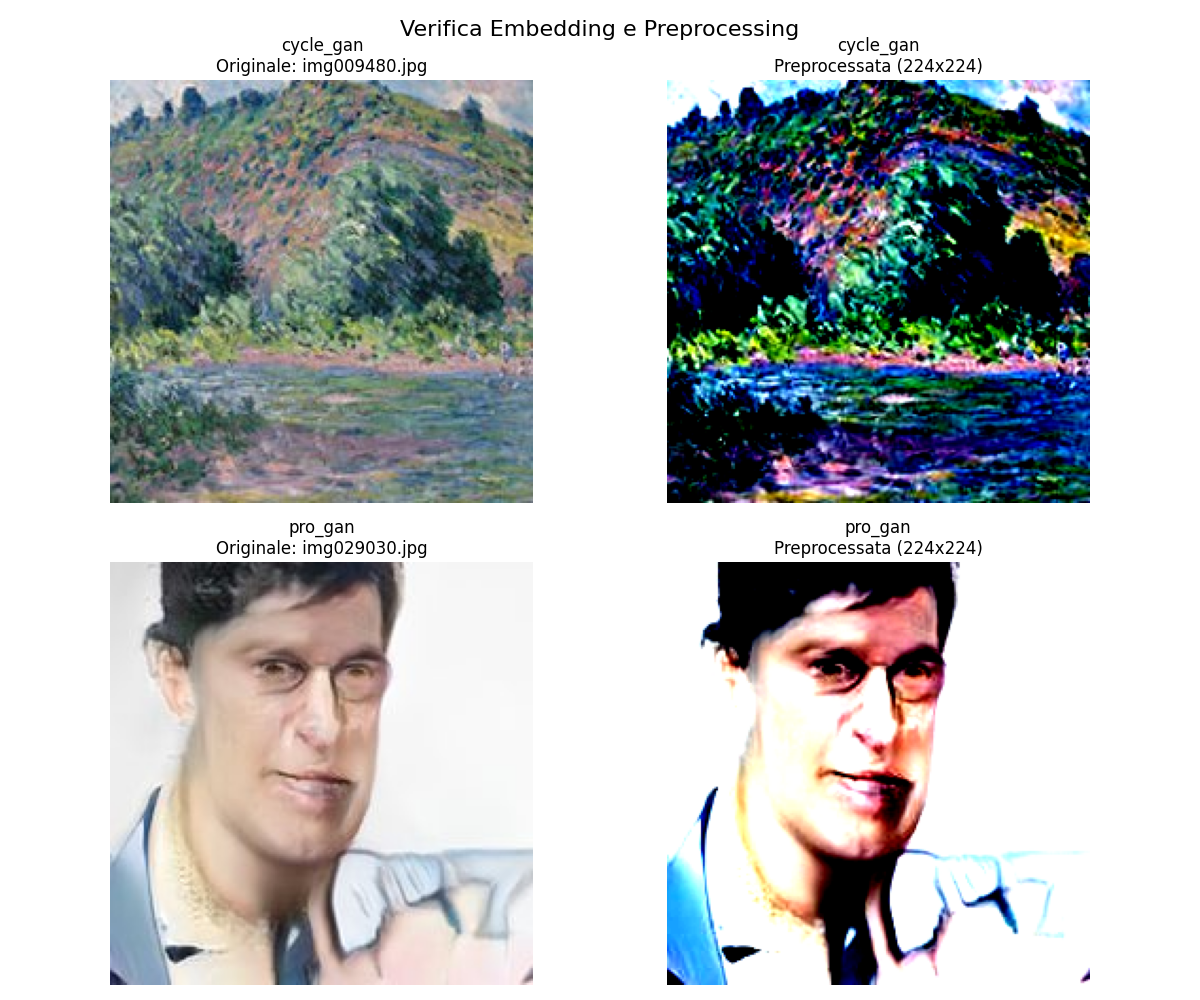


=== FASE 4: PREPARAZIONE DATI COMBINATI ===
Dimensioni dataset finali:
- Training: 38647 (70.0%)
- Validazione: 5520 (10.0%)
- Test: 11043 (20.0%)
TOTALE IMMAGINI: 55210

=== PREPARAZIONE DATI PER TRIPLETTE ===

Distribuzione dati di training:
  cycle_gan/fake: 5369 esempi
  cycle_gan/real: 5307 esempi
  pro_gan/fake: 13955 esempi
  pro_gan/real: 14016 esempi

=== FASE 5: ADDESTRAMENTO MODELLO TRIPLET CON SVM ===

[FASE 1/6] Inizializzazione modelli...
[FASE 2/6] Generazione delle triplette...

[DEBUG] Distribuzione dati per generazione triplette:
- Totale esempi: 38647
- Classi uniche: ['fake' 'real']
- Sorgenti uniche: ['cycle_gan' 'pro_gan']
  real/cycle_gan: 5307 esempi
  real/pro_gan: 14016 esempi
  fake/cycle_gan: 5369 esempi
  fake/pro_gan: 13955 esempi
Combinazioni valide per triplette: [('real', 'cycle_gan'), ('real', 'pro_gan'), ('fake', 'cycle_gan'), ('fake', 'pro_gan')]


Generazione triplette: 100%|██████████| 77294/77294 [00:00<00:00, 126649.27it/s]



[STATS] Tipologie di triplette generate:
- Stessa sorgente: 77294
- Sorgente incrociata: 0
- Qualsiasi sorgente valida: 0
- Fallback: 0
Triplette totali generate: 77294/77294
Batch creati: 604
[FASE 2bis/6] Generazione triplette di validazione...

[DEBUG] Distribuzione dati per generazione triplette:
- Totale esempi: 5520
- Classi uniche: ['fake' 'real']
- Sorgenti uniche: ['cycle_gan' 'pro_gan']
  real/cycle_gan: 745 esempi
  real/pro_gan: 2015 esempi
  fake/cycle_gan: 737 esempi
  fake/pro_gan: 2023 esempi
Combinazioni valide per triplette: [('real', 'cycle_gan'), ('real', 'pro_gan'), ('fake', 'cycle_gan'), ('fake', 'pro_gan')]


Generazione triplette: 100%|██████████| 5520/5520 [00:00<00:00, 124194.34it/s]



[STATS] Tipologie di triplette generate:
- Stessa sorgente: 5520
- Sorgente incrociata: 0
- Qualsiasi sorgente valida: 0
- Fallback: 0
Triplette totali generate: 5520/5520
Batch creati: 44
[FASE 3/6] Addestramento rete Triplet...



Epoch 1/20
  Training Loss: 0.3101 | Validation Loss: 0.1027
  Delta Loss: 0.2074


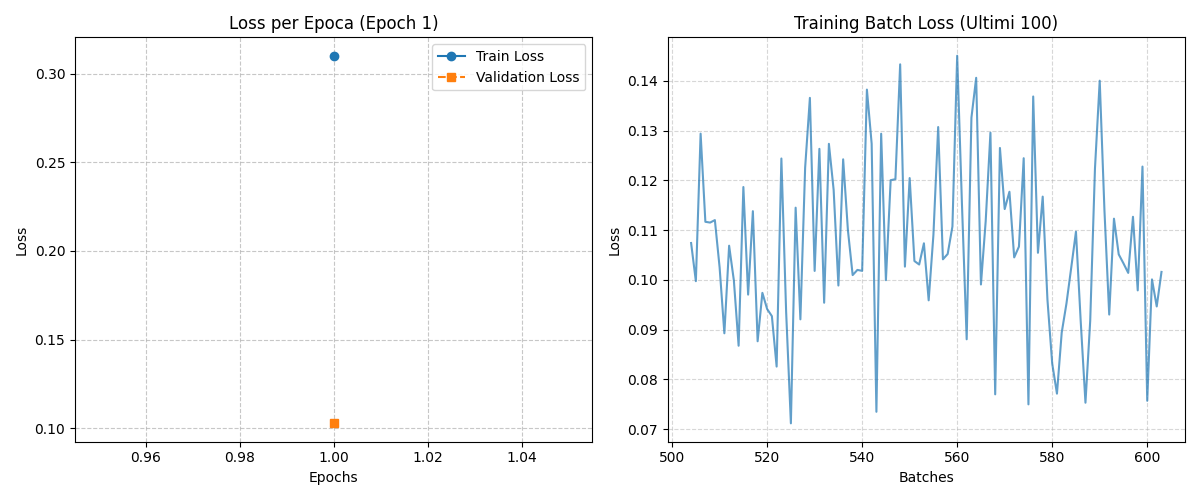

Checkpoint salvato in triplet_checkpoint.pt



Epoch 2/20
  Training Loss: 0.0810 | Validation Loss: 0.0787
  Delta Loss: 0.0023


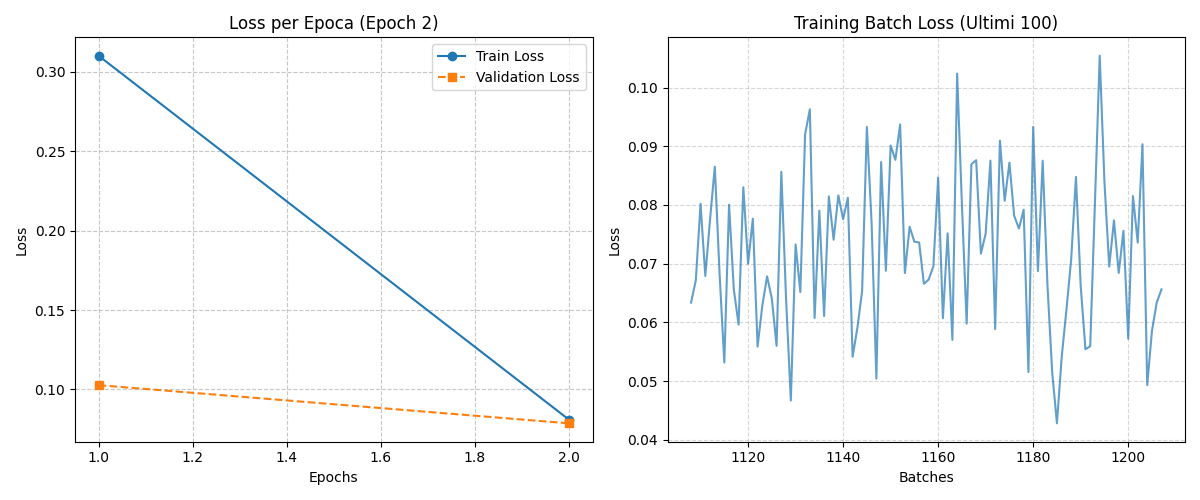

Checkpoint salvato in triplet_checkpoint.pt



Epoch 3/20
  Training Loss: 0.0592 | Validation Loss: 0.0673
  Delta Loss: -0.0081


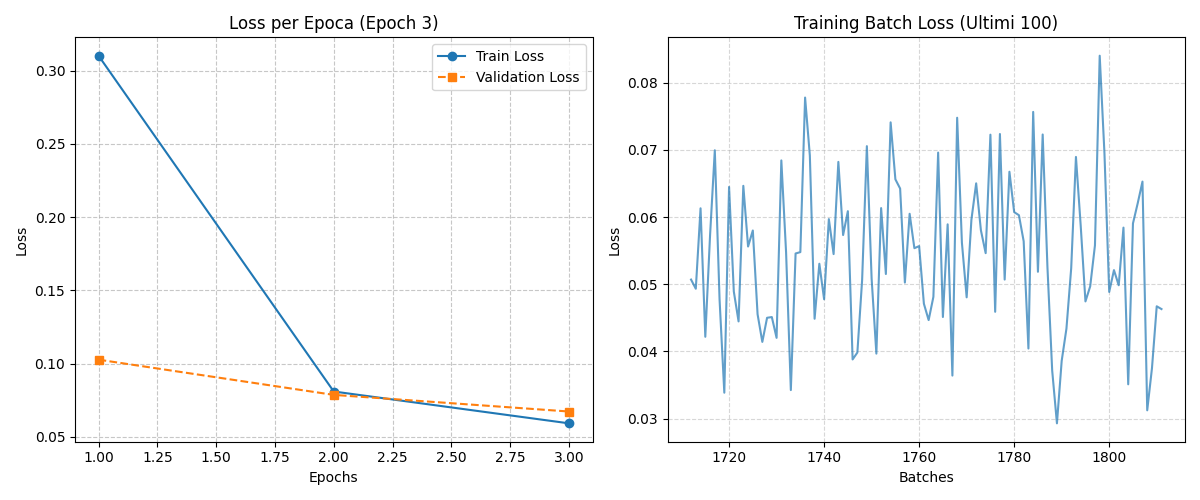

Checkpoint salvato in triplet_checkpoint.pt



Epoch 4/20
  Training Loss: 0.0440 | Validation Loss: 0.0627
  Delta Loss: -0.0187


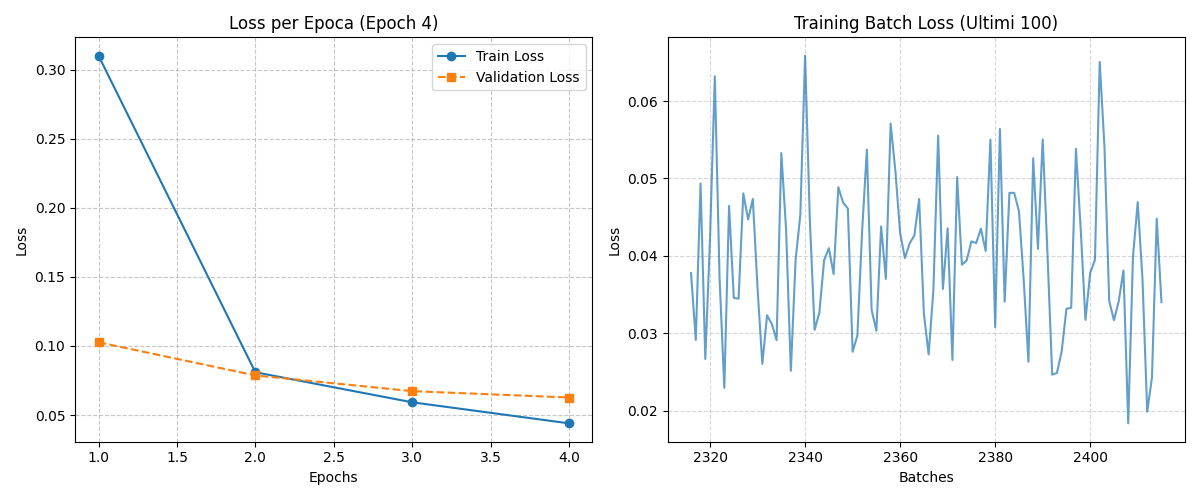

Checkpoint salvato in triplet_checkpoint.pt



Epoch 5/20
  Training Loss: 0.0318 | Validation Loss: 0.0607
  Delta Loss: -0.0289


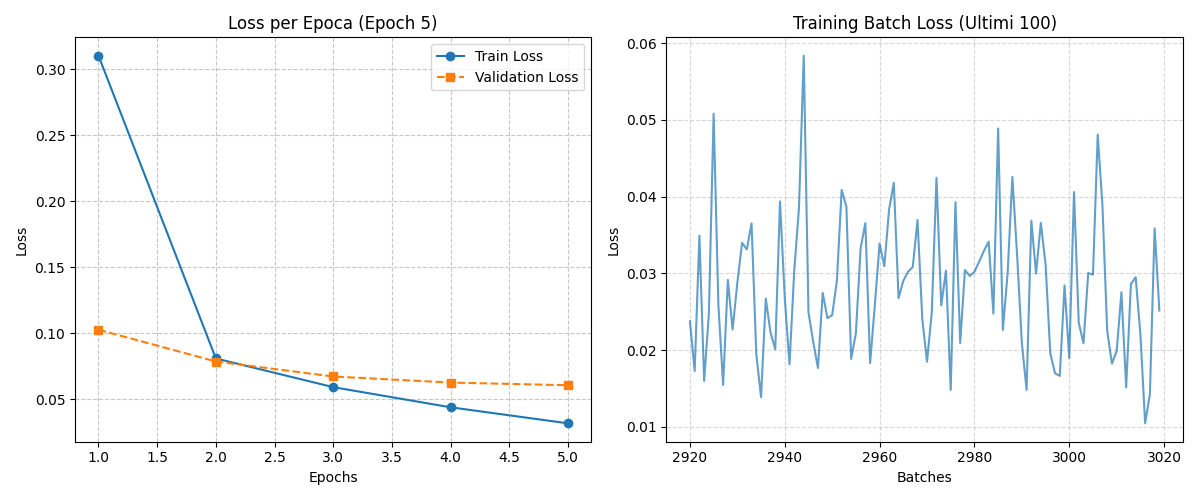

Checkpoint salvato in triplet_checkpoint.pt



Epoch 6/20
  Training Loss: 0.0220 | Validation Loss: 0.0609
  Delta Loss: -0.0389


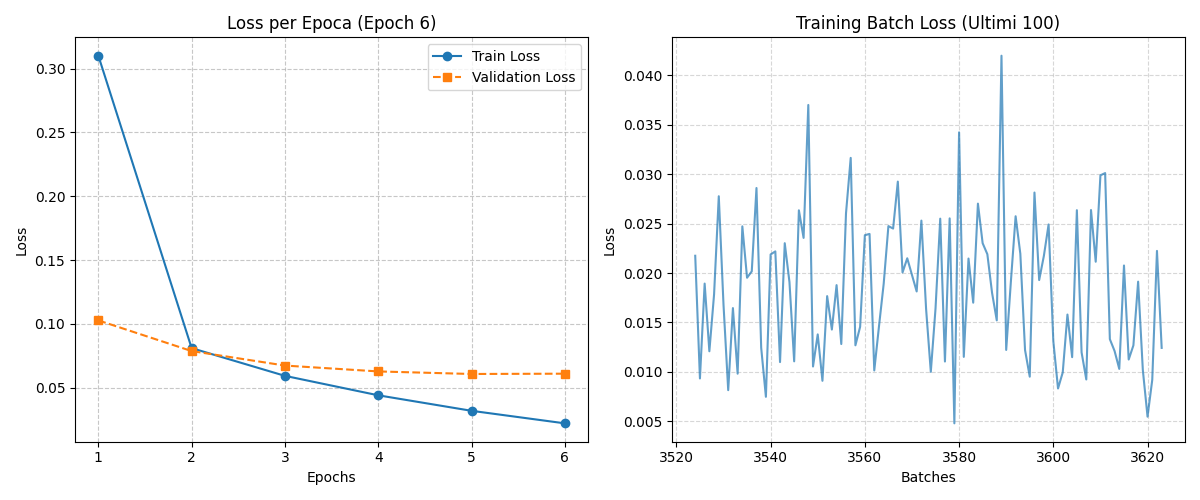


Epoch 7/20
  Training Loss: 0.0149 | Validation Loss: 0.0648
  Delta Loss: -0.0499


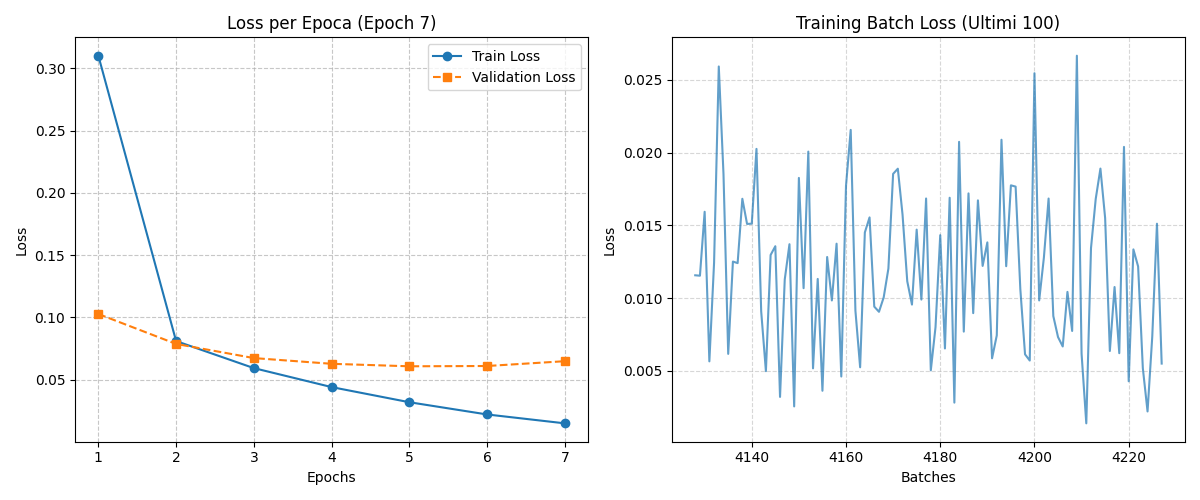


Epoch 8/20
  Training Loss: 0.0103 | Validation Loss: 0.0711
  Delta Loss: -0.0609


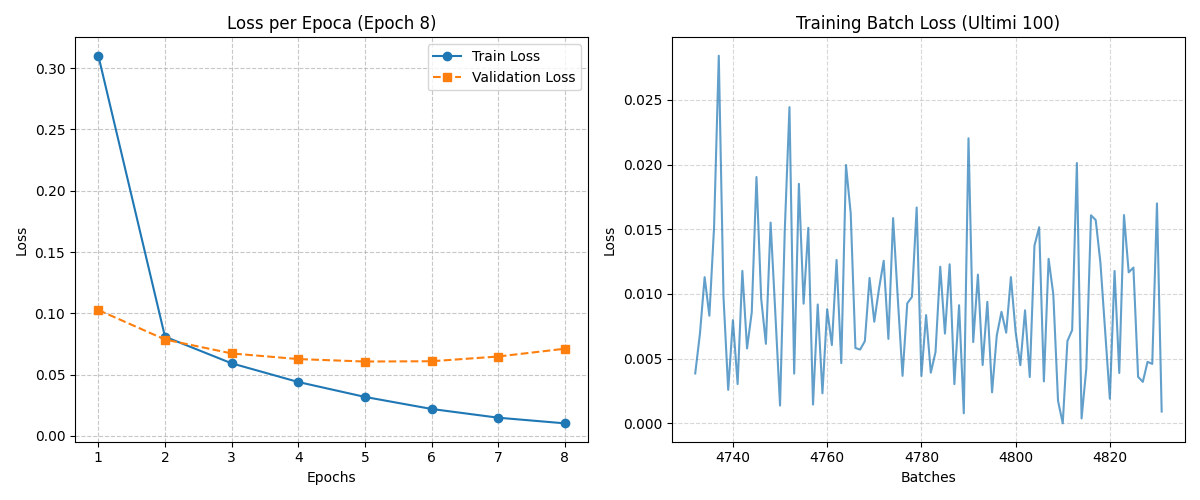


Epoch 9/20
  Training Loss: 0.0078 | Validation Loss: 0.0715
  Delta Loss: -0.0637


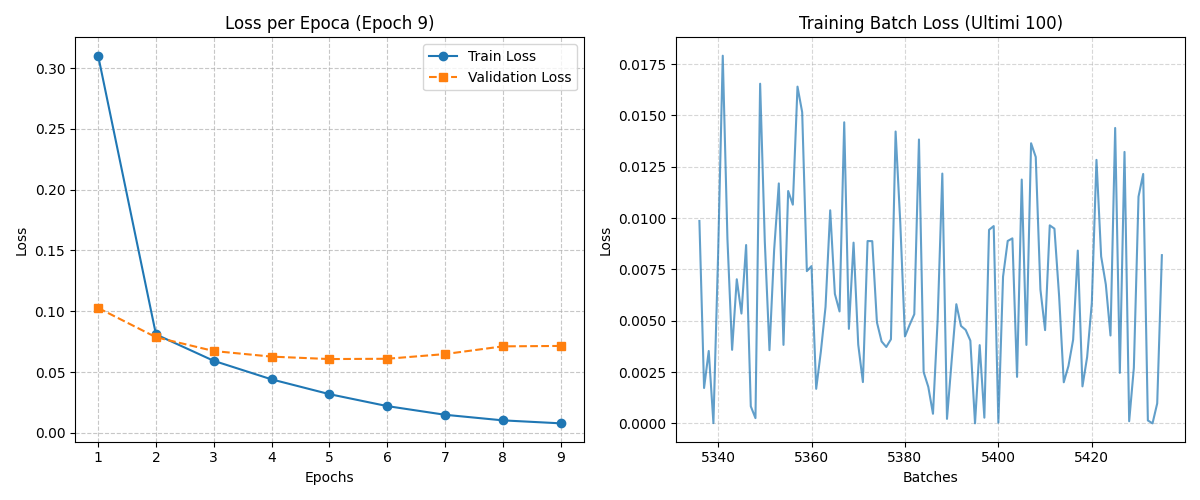


Epoch 10/20
  Training Loss: 0.0061 | Validation Loss: 0.0839
  Delta Loss: -0.0779


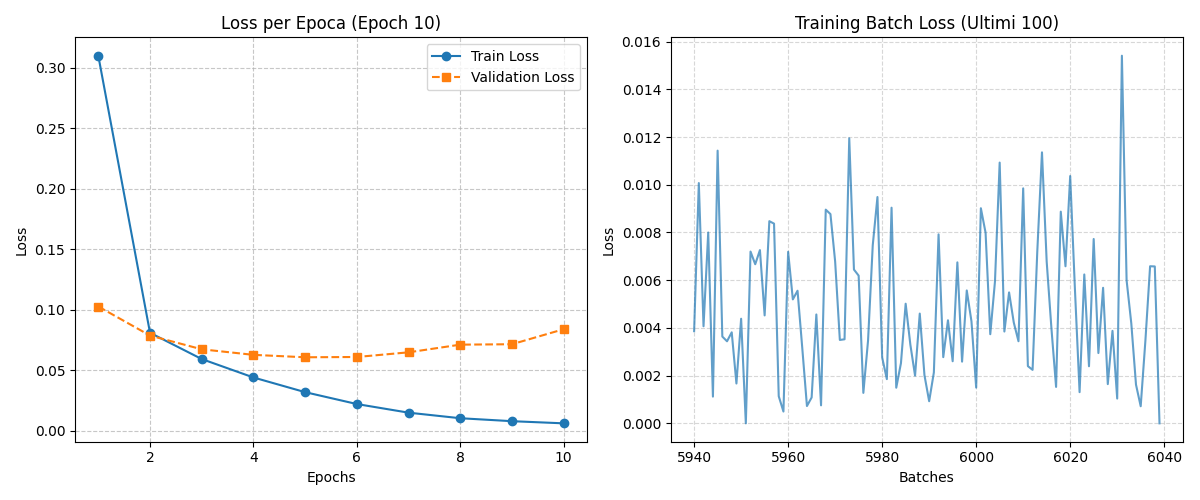


[!] Early stopping attivato! Caricamento migliori pesi...
Checkpoint caricato correttamente

[FASE 4/6] Generazione embedding raffinati...
[FASE 5/6] Addestramento SVM...


C:\Users\39327\AppData\Local\Temp\ipykernel_20760\1161170295.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('triplet_checkpoint.pt')


[FASE 6/6] Valutazione finale...

Risultati Training Set:
Accuracy: 0.9548
Precision: 0.9551
Recall: 0.9545
F1-Score: 0.9548

Risultati Validation Set:
Accuracy: 0.9286
Precision: 0.9243
Recall: 0.9337
F1-Score: 0.9290

Risultati Test Set:
Accuracy: 0.9254
Precision: 0.9255
Recall: 0.9252
F1-Score: 0.9254

[INFO] Generazione grafico finale delle loss...


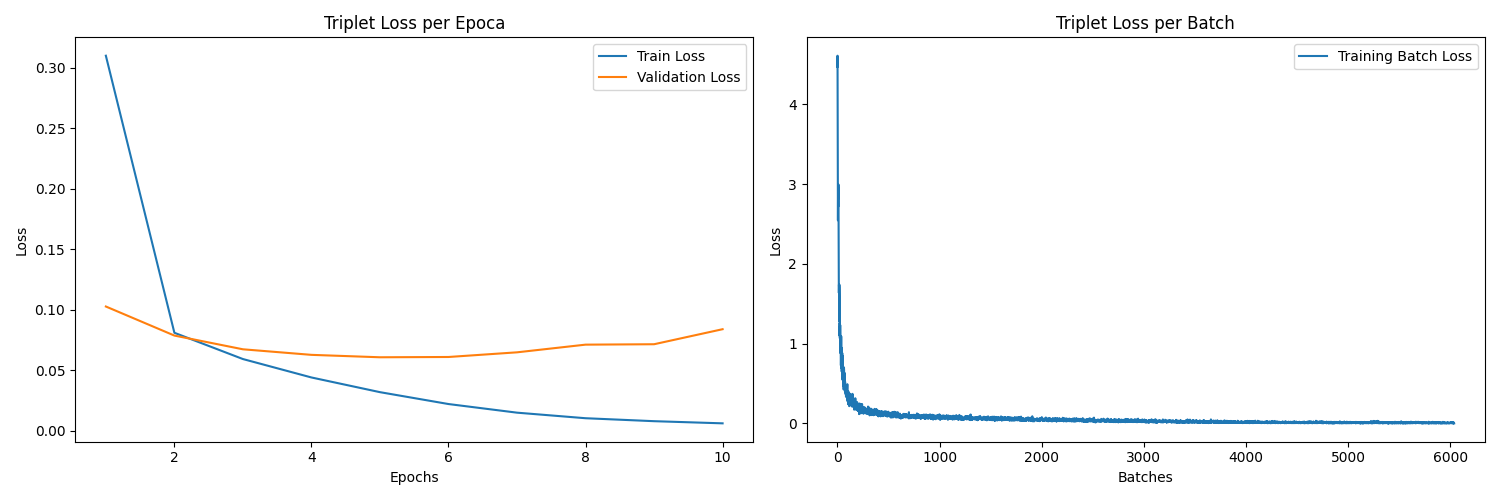


[INFO] Generazione grafico distribuzione distanze...


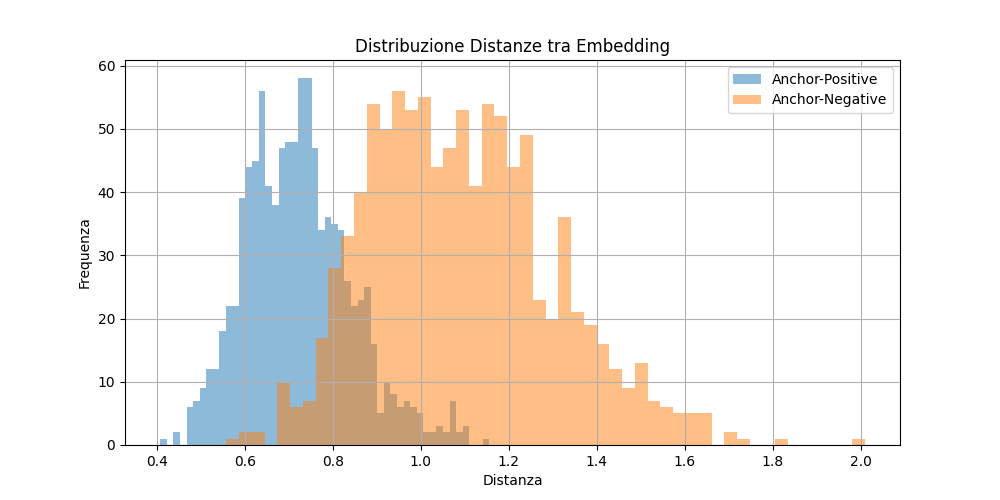


=== FASE 6: SALVATAGGIO RISULTATI ===
[SUCCESSO] Risultati e modelli salvati correttamente
  - combined_model_results.pkl: Metriche e dimensioni dataset
  - triplet_model_weights.pth: Pesi modello Triplet
  - svm_model.pkl: Modello SVM addestrato

=== FASE 7: VISUALIZZAZIONI FINALI ===


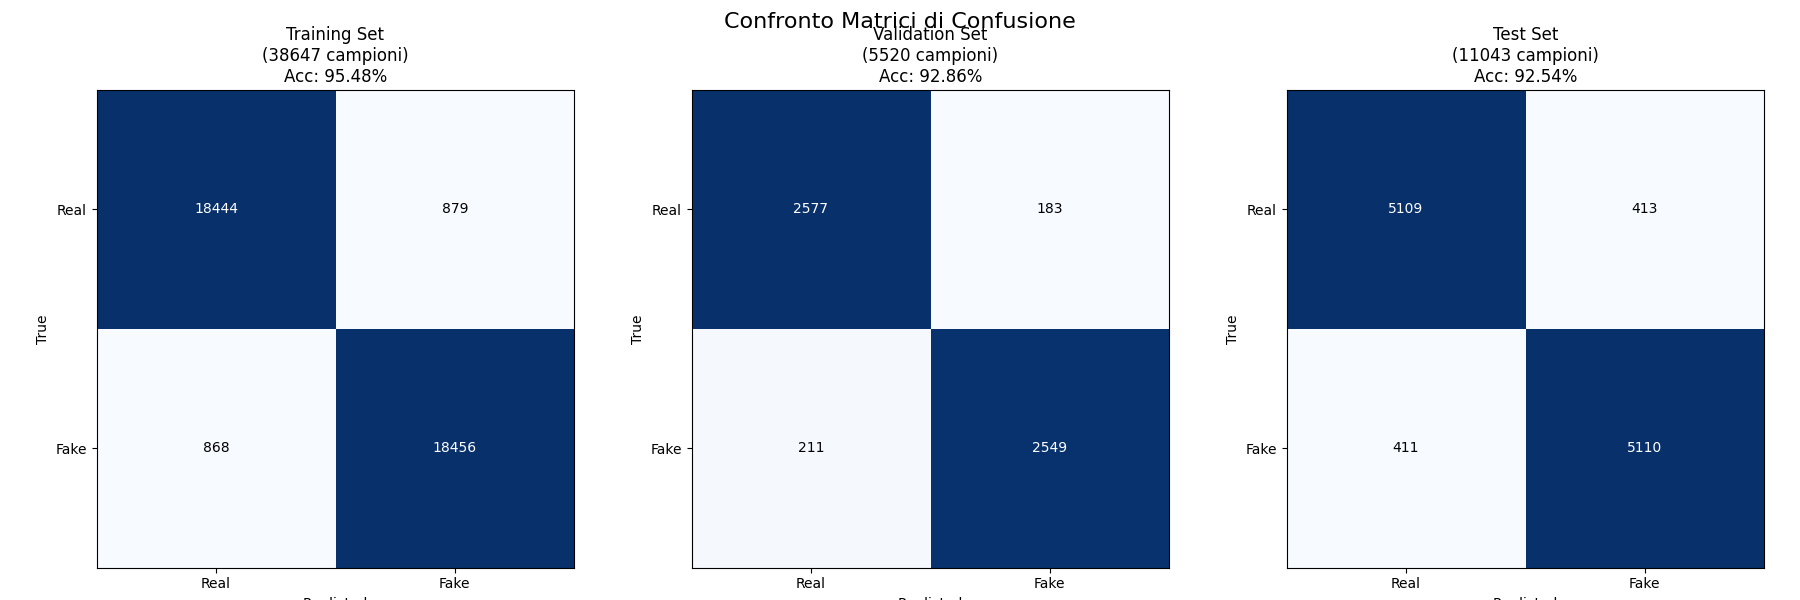

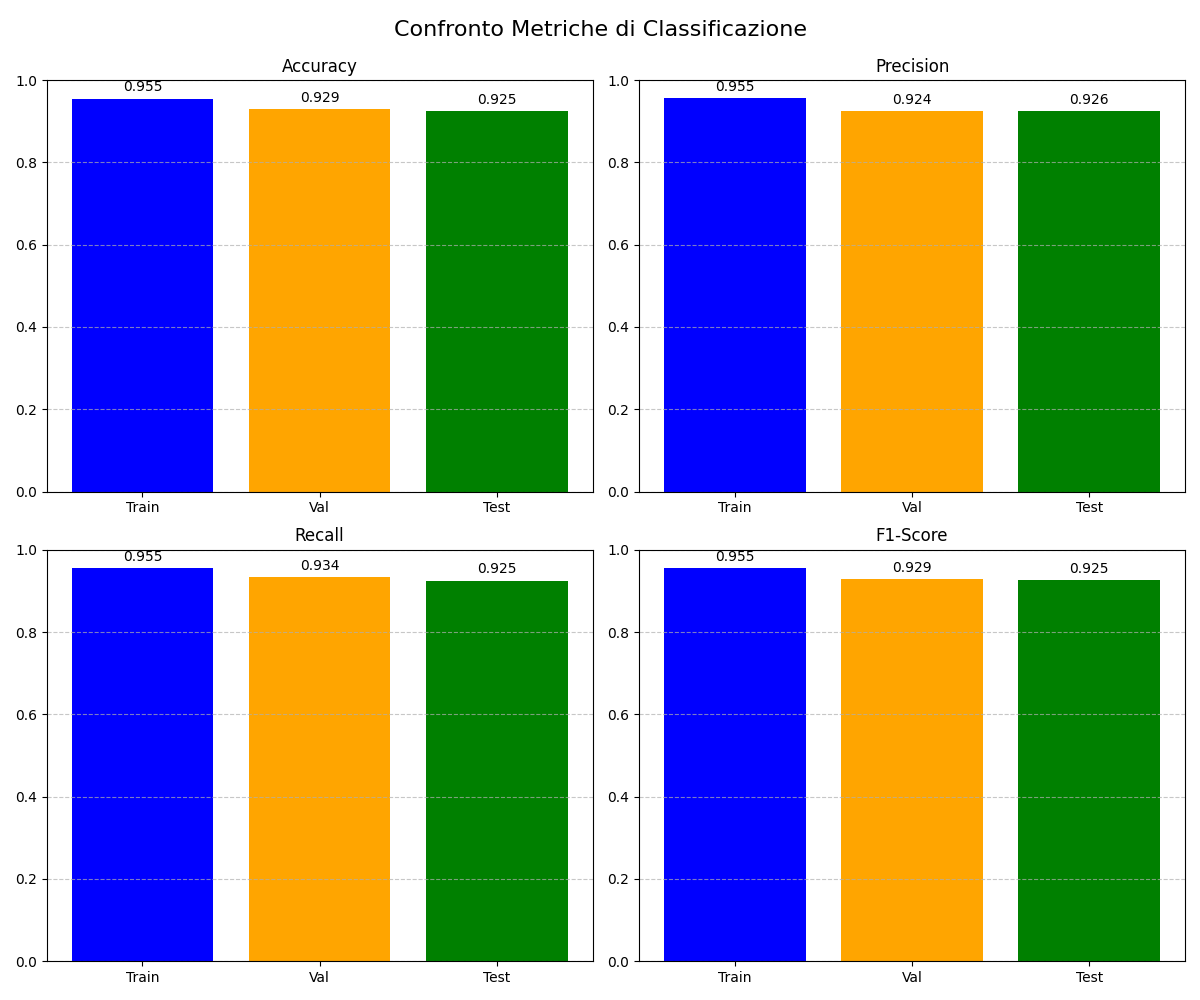


[INFO] Generazione t-SNE per gli embedding raffinati...


C:\Users\39327\AppData\Local\Temp\ipykernel_20760\1161170295.py:759: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('viridis', 2),


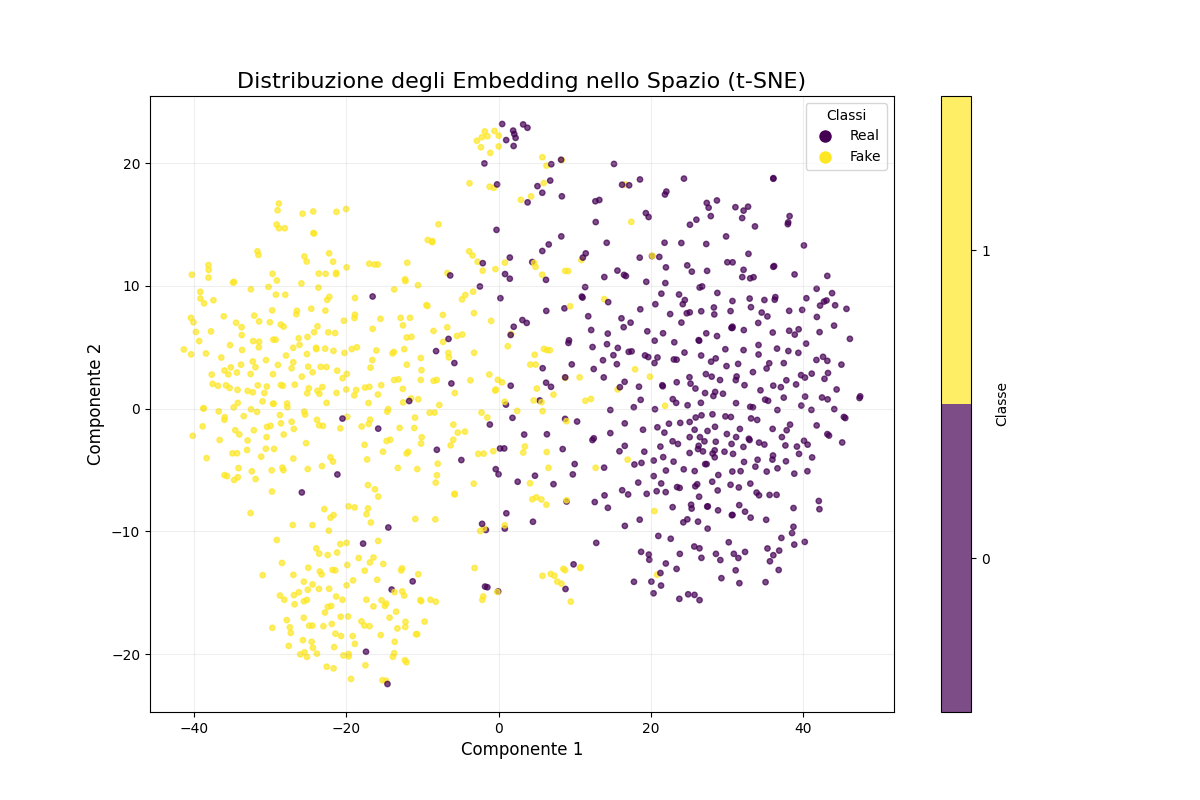

In [84]:
def evaluate_model_combined():
    # === FASE 1: SETUP INIZIALE ===
    print("\n=== FASE 1: CONFIGURAZIONE INIZIALE ===")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Dispositivo selezionato: {device}")

    model, preprocess = clip.load("ViT-B/32", device=device)

    BASE_DATASET_PATH_CYCLE = Path("..") / "dataset" / "cycle_gan"
    BASE_DATASET_PATH_CYCLE = BASE_DATASET_PATH_CYCLE.resolve()
    BASE_DATASET_PATH_PRO = Path("..") / "dataset" / "pro_gan"
    BASE_DATASET_PATH_PRO = BASE_DATASET_PATH_PRO.resolve()

    # === FASE 2: CARICAMENTO DATASET COMBINATO ===
    print("\n=== FASE 2: CARICAMENTO DATASET COMBINATO ===")
    try:
        # Caricamento CycleGAN (indice 5)
        dataset_cycle_gan = get_datasets(metadata_list, [5])[0]
        image_paths_cycle = [str((BASE_DATASET_PATH_CYCLE / row['image_path']).resolve())
                             for _, row in dataset_cycle_gan.iterrows()]

        # Caricamento ProGAN (indice 24)
        dataset_pro_gan = get_datasets(metadata_list, [24])[0]
        image_paths_pro = [str((BASE_DATASET_PATH_PRO / row['image_path']).resolve())
                           for _, row in dataset_pro_gan.iterrows()]

        # Combinazione dei dataset
        all_image_paths = image_paths_cycle + image_paths_pro
        combined_dataset = pd.concat([dataset_cycle_gan, dataset_pro_gan], ignore_index=True)

        print(f"[SUCCESSO] Caricate {len(all_image_paths)} immagini totali")
        print(f"  - CycleGAN: {len(image_paths_cycle)} immagini")
        print(f"  - ProGAN: {len(image_paths_pro)} immagini")

    except Exception as e:
        print(f"[ERRORE CRITICO] Caricamento dataset fallito: {str(e)}")
        exit()

    # === FASE 3: ESTRAZIONE EMBEDDING ===
    print("\n=== FASE 3: ESTRAZIONE EMBEDDING CLIP ===")
    try:
        # Definisci datasets_info
        datasets_info = [
            (dataset_cycle_gan, BASE_DATASET_PATH_CYCLE),
            (dataset_pro_gan, BASE_DATASET_PATH_PRO)
        ]

        # Estrazione embedding
        embeddings_cycle, labels_cycle, sources_cycle = generate_and_save_embeddings(
            image_paths_cycle, model, datasets_info, device=device
        )

        embeddings_pro, labels_pro, sources_pro = generate_and_save_embeddings(
            image_paths_pro, model, datasets_info, device=device
        )

        # Combinazione degli embedding
        embeddings_combined = np.concatenate((embeddings_cycle, embeddings_pro))
        labels_combined = np.concatenate((labels_cycle, labels_pro))
        sources_combined = np.concatenate((sources_cycle, sources_pro))

        print(f"[SUCCESSO] Generati {len(embeddings_combined)} embedding totali")

        # === FASE 3bis: VERIFICA EMBEDDING ===
        print("\n=== FASE 3bis: VERIFICA EMBEDDING PER DATASET COMBINATO ===")
        embeddings_dict_combined = {}
        for i, img_path in enumerate(all_image_paths):
            abs_path = Path(img_path).resolve()
            normalized_path = str(abs_path).lower().replace("\\", "/")
            embeddings_dict_combined[normalized_path] = {
                'target': labels_combined[i],
                'embedding': embeddings_combined[i]
            }

        verifica_embedding_clip_multiple(
            model=model,
            preprocess=preprocess,
            embeddings_dict=embeddings_dict_combined,
            datasets_info=datasets_info,
            device=device
        )

    except Exception as e:
        print(f"[ERRORE] Estrazione embedding fallita: {str(e)}")
        exit()

    # === FASE 4: PREPARAZIONE DATI ===
    print("\n=== FASE 4: PREPARAZIONE DATI COMBINATI (70/20/10) ===")
    try:
        # Split 70-30
        X_train, X_temp, y_train, y_temp, s_train, s_temp = train_test_split(
            embeddings_combined,
            labels_combined,
            sources_combined,
            test_size=0.3,
            stratify=labels_combined,
            random_state=42
        )

        # Split 20-10 (dal 30% temporaneo: 20% test, 10% validation)
        X_test, X_val, y_test, y_val, s_test, s_val = train_test_split(
            X_temp,
            y_temp,
            s_temp,
            test_size=1/3,  # 10% del totale = 1/3 del 30%
            stratify=y_temp,
            random_state=42
        )

        print("Dimensioni dataset:")
        print(f"- Training: {len(X_train)} ({(len(X_train)/len(embeddings_combined))*100:.1f}%)")
        print(f"- Test: {len(X_test)} ({(len(X_test)/len(embeddings_combined))*100:.1f}%)")
        print(f"- Validazione: {len(X_val)} ({(len(X_val)/len(embeddings_combined))*100:.1f}%)")
        print(f"TOTALE IMMAGINI: {len(embeddings_combined)}")

    except Exception as e:
        print(f"[ERRORE] Preparazione dati fallita: {str(e)}")
        exit()

    # === FASE 5: ADDESTRAMENTO MODELLO SU DATASET COMBINATO ===
    results = None  # Inizializzazione per prevenire ReferenceError

    try:
        # Caricamento dati combinati (dataset 5 e 24)
        combined_data = pd.concat([datasets[5], datasets[24]], ignore_index=True)

        # Split in training e validation
        train_df, val_df = train_test_split(combined_data, test_size=0.2, random_state=42)

        # Creazione DataLoader
        train_loader = create_data_loader(train_df, batch_size=BATCH_SIZE)
        val_loader = create_data_loader(val_df, batch_size=BATCH_SIZE)

        # Inizializzazione modello
        model = SimpleClassifier(input_dim=EMBEDDING_DIM, num_classes=2).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        criterion = nn.CrossEntropyLoss()

        # Addestramento
        for epoch in range(EPOCHS):
            train_loss = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
            val_loss, val_acc = evaluate_model(model, val_loader, criterion, DEVICE)

            print(f"Epoch {epoch+1}/{EPOCHS}")
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

            # Early stopping check
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping attivato")
                break

        # Caricamento miglior modello
        model.load_state_dict(torch.load(early_stopping.path))

        # Valutazione finale
        _, final_acc = evaluate_model(model, val_loader, criterion, DEVICE)
        results = {
            'final_accuracy': final_acc,
            'total_epochs': epoch + 1
        }
        print(f"Addestramento completato! Accuratezza finale: {final_acc:.4f}")

    except Exception as e:
        print(f"[ERRORE GRAVE] Addestramento fallito: {str(e)}")
        results = {'error': str(e)}  # Mantenere traccia dell'errore

    # === FASE 6: SALVATAGGIO RISULTATI COMBINATI ===
    try:
        if results:
            with open('combined_training_results.pkl', 'wb') as f:
                pickle.dump(results, f)
            print("Risultati salvati con successo!")
        else:
            print("Nessun risultato da salvare")
    except Exception as e:
        print(f"[ERRORE] Salvataggio risultati fallito: {str(e)}")

def evaluate_model(X_train, X_val, X_test, y_train, y_val, y_test, s_train, s_val, device):
    # === FASE 1: INIZIALIZZAZIONE MODELLO ===
    print("\n[FASE 1/6] Inizializzazione modelli...")
    triplet_model = TripletModel().to(device)
    criterion = TripletLoss(margin=0.2)
    optimizer = optim.Adam(triplet_model.parameters(), lr=1e-4)

    # Configurazione early stopping
    early_stopping = EarlyStopping(
        patience=5,
        verbose=True,
        delta=0.001,
        path='triplet_checkpoint.pt',
        monitor='val_loss',
        mode='min'
    )

    # === FASE 2: PREPARAZIONE TRIPLETTE ===
    print("[FASE 2/6] Generazione delle triplette...")
    triplet_batches = generate_triplets_fixed_batch(
        embeddings=X_train,
        labels=y_train,
        sources=s_train,
        batch_size=128,
        n_triplets=len(X_train) * 2  # Genera il doppio delle triplette rispetto agli esempi
    )

    # === FASE 2 BIS: GENERAZIONE TRIPLETTE DI VALIDAZIONE ===
    print("[FASE 2bis/6] Generazione triplette di validazione...")
    val_triplet_batches = generate_triplets_fixed_batch(
        embeddings=X_val,
        labels=y_val,
        sources=s_val,
        batch_size=128,
        n_triplets=len(X_val)  # Numero di triplette pari agli esempi di validazione
    )

    # === FASE 3/6: ADDESTRAMENTO TRIPLET MODEL CON VALIDAZIONE ===
    print("[FASE 3/6] Addestramento rete Triplet...")
    train_losses = []  # Loss medie per epoca (training)
    val_losses = []    # Loss medie per epoca (validation)
    batch_losses = []  # Loss per ogni batch (training)

    num_epochs = 20
    for epoch in range(num_epochs):
        # Fase di training
        triplet_model.train()
        epoch_train_loss = 0.0

        progress_bar = tqdm(triplet_batches, desc=f'Epoch {epoch+1}', leave=False)
        for batch_idx, batch in enumerate(progress_bar):
            anchor, positive, negative = batch

            # Converti in tensori e sposta su device
            anchor = torch.FloatTensor(anchor).to(device)
            positive = torch.FloatTensor(positive).to(device)
            negative = torch.FloatTensor(negative).to(device)

            # Forward pass
            optimizer.zero_grad()
            anchor_emb = triplet_model(anchor)
            positive_emb = triplet_model(positive)
            negative_emb = triplet_model(negative)

            # Calcola loss e backpropagation
            loss = criterion(anchor_emb, positive_emb, negative_emb)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            batch_losses.append(loss.item())
            progress_bar.set_postfix({'train_batch_loss': loss.item()})

        avg_train_loss = epoch_train_loss / len(triplet_batches)
        train_losses.append(avg_train_loss)

        # Fase di validazione
        triplet_model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for val_batch in val_triplet_batches:
                anchor_val, positive_val, negative_val = val_batch

                anchor_val = torch.FloatTensor(anchor_val).to(device)
                positive_val = torch.FloatTensor(positive_val).to(device)
                negative_val = torch.FloatTensor(negative_val).to(device)

                a_emb_val = triplet_model(anchor_val)
                p_emb_val = triplet_model(positive_val)
                n_emb_val = triplet_model(negative_val)

                val_loss = criterion(a_emb_val, p_emb_val, n_emb_val)
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_triplet_batches)
        val_losses.append(avg_val_loss)

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"  Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
        print(f"  Delta Loss: {avg_train_loss - avg_val_loss:.4f}")

        # Visualizzazione in tempo reale delle loss
        try:
            # Plot temporaneo durante l'addestramento
            plt.figure(figsize=(12, 5))

            # Grafico sinistro: Loss per epoca
            plt.subplot(1, 2, 1)
            plt.plot(range(1, len(train_losses)+1), train_losses, 'o-', label='Train Loss')
            plt.plot(range(1, len(val_losses)+1), val_losses, 's--', label='Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title(f'Loss per Epoca (Epoch {epoch+1})')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.legend()

            # Grafico destro: Loss per batch (ultimi 100 batch)
            plt.subplot(1, 2, 2)
            start_idx = max(0, len(batch_losses)-100)
            plt.plot(range(start_idx, len(batch_losses)), batch_losses[start_idx:], alpha=0.7)
            plt.xlabel('Batches')
            plt.ylabel('Loss')
            plt.title(f'Training Batch Loss (Ultimi 100)')
            plt.grid(True, linestyle='--', alpha=0.5)

            plt.tight_layout()
            plt.show(block=False)  # Non blocca l'esecuzione
            plt.pause(0.1)         # Mostra per 0.1 secondi
            plt.close()            # Chiude la figura dopo la visualizzazione

        except Exception as e:
            print(f"[WARNING] Errore nel plotting: {str(e)}")

        # Early stopping
        early_stopping(avg_val_loss, triplet_model)
        if early_stopping.early_stop:
            print("\n[!] Early stopping attivato! Caricamento migliori pesi...")
            try:
                checkpoint = torch.load('triplet_checkpoint.pt')
                triplet_model.load_state_dict(checkpoint['model_state_dict'])
                print("Checkpoint caricato correttamente")
            except Exception as e:
                print(f"[ERRORE] Caricamento checkpoint fallito: {str(e)}")
            break

    # === FASE 4: RIFINITURA EMBEDDING ===
    print("\n[FASE 4/6] Generazione embedding raffinati...")
    with torch.no_grad():
        # Converti i dati in tensori e calcola gli embedding raffinati
        X_train_refined = triplet_model(torch.FloatTensor(X_train).to(device)).cpu().numpy()
        X_val_refined = triplet_model(torch.FloatTensor(X_val).to(device)).cpu().numpy()
        X_test_refined = triplet_model(torch.FloatTensor(X_test).to(device)).cpu().numpy()

    # === FASE 5: CLASSIFICAZIONE SVM ===
    print("[FASE 5/6] Addestramento SVM...")
    svm = SVC(kernel='linear', C=1.0, random_state=42)
    # Addestramento su training set raffinato
    svm.fit(X_train_refined, y_train)

    # === FASE 6: VALUTAZIONE FINALE ===
    print("[FASE 6/6] Valutazione finale...")

    # Predizioni
    y_train_pred = svm.predict(X_train_refined)
    y_val_pred = svm.predict(X_val_refined)
    y_test_pred = svm.predict(X_test_refined)

    # Calcolo metriche
    def calculate_metrics(y_true, y_pred):
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='binary', pos_label='real')  # Assumiamo 'real' come classe positiva
        recall = recall_score(y_true, y_pred, average='binary', pos_label='real')
        f1 = f1_score(y_true, y_pred, average='binary', pos_label='real')
        cm = confusion_matrix(y_true, y_pred, labels=['real', 'fake'])
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': cm
        }

    metrics = {
        'train': calculate_metrics(y_train, y_train_pred),
        'val': calculate_metrics(y_val, y_val_pred),
        'test': calculate_metrics(y_test, y_test_pred)
    }

    # Stampa risultati
    print("\nRisultati Training Set:")
    print(f"Accuracy: {metrics['train']['accuracy']:.4f}")
    print(f"Precision: {metrics['train']['precision']:.4f}")
    print(f"Recall: {metrics['train']['recall']:.4f}")
    print(f"F1-Score: {metrics['train']['f1']:.4f}")

    print("\nRisultati Validation Set:")
    print(f"Accuracy: {metrics['val']['accuracy']:.4f}")
    print(f"Precision: {metrics['val']['precision']:.4f}")
    print(f"Recall: {metrics['val']['recall']:.4f}")
    print(f"F1-Score: {metrics['val']['f1']:.4f}")

    print("\nRisultati Test Set:")
    print(f"Accuracy: {metrics['test']['accuracy']:.4f}")
    print(f"Precision: {metrics['test']['precision']:.4f}")
    print(f"Recall: {metrics['test']['recall']:.4f}")
    print(f"F1-Score: {metrics['test']['f1']:.4f}")

    # Plot finale delle loss
    print("\n[INFO] Generazione grafico finale delle loss...")
    plot_losses(
        train_losses=train_losses,
        val_losses=val_losses,
        batch_losses=batch_losses,
        num_epochs=len(train_losses)
    )

    # Plot distribuzione distanze
    try:
        print("\n[INFO] Generazione grafico distribuzione distanze...")
        plot_distance_distribution(triplet_batches, triplet_model, device=device)
    except Exception as e:
        print(f"[WARNING] Errore nel plot delle distanze: {str(e)}")

    return {
        'triplet_model': triplet_model,
        'svm': svm,
        'metrics': metrics,
        'embeddings': {
            'train': X_train_refined,
            'val': X_val_refined,
            'test': X_test_refined
        }
    }
if __name__ == "__main__":
    print("="*50)
    print("AVVIO VALUTAZIONE MODELLO COMBINATO")
    print("="*50)

    try:
        # === FASE 1: SETUP INIZIALE ===
        print("\n=== FASE 1: CONFIGURAZIONE INIZIALE ===")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"[INFO] Dispositivo selezionato: {device}")

        # Carica modello CLIP
        model, preprocess = clip.load("ViT-B/32", device=device)

        # Definizione percorsi dataset
        BASE_DATASET_PATH_CYCLE = Path("..") / "dataset" / "cycle_gan"
        BASE_DATASET_PATH_CYCLE = BASE_DATASET_PATH_CYCLE.resolve()
        BASE_DATASET_PATH_PRO = Path("..") / "dataset" / "pro_gan"
        BASE_DATASET_PATH_PRO = BASE_DATASET_PATH_PRO.resolve()

        print(f"[INFO] Percorso Cycle-GAN: {BASE_DATASET_PATH_CYCLE}")
        print(f"[INFO] Percorso Pro-GAN: {BASE_DATASET_PATH_PRO}")

        # === FASE 2: CARICAMENTO DATASET COMBINATO ===
        print("\n=== FASE 2: CARICAMENTO DATASET COMBINATO ===")
        try:
            # Caricamento CycleGAN (indice 5)
            dataset_cycle_gan = get_datasets(metadata_list, [5])[0]
            image_paths_cycle = [str((BASE_DATASET_PATH_CYCLE / row['image_path']).resolve())
                                 for _, row in dataset_cycle_gan.iterrows()]

            # Caricamento ProGAN (indice 24)
            dataset_pro_gan = get_datasets(metadata_list, [24])[0]
            image_paths_pro = [str((BASE_DATASET_PATH_PRO / row['image_path']).resolve())
                               for _, row in dataset_pro_gan.iterrows()]

            # Combinazione dei dataset
            all_image_paths = image_paths_cycle + image_paths_pro
            combined_dataset = pd.concat([dataset_cycle_gan, dataset_pro_gan], ignore_index=True)

            print(f"[SUCCESSO] Caricate {len(all_image_paths)} immagini totali")
            print(f"  - CycleGAN: {len(image_paths_cycle)} immagini")
            print(f"  - ProGAN: {len(image_paths_pro)} immagini")

        except Exception as e:
            print(f"[ERRORE CRITICO] Caricamento dataset fallito: {str(e)}")
            exit()

        # === FASE 3: ESTRAZIONE EMBEDDING ===
        print("\n=== FASE 3: ESTRAZIONE EMBEDDING CLIP ===")
        try:
            # Definisci datasets_info
            datasets_info = [
                (dataset_cycle_gan, BASE_DATASET_PATH_CYCLE),
                (dataset_pro_gan, BASE_DATASET_PATH_PRO)
            ]

            # Estrazione embedding
            embeddings_cycle, labels_cycle, sources_cycle = generate_and_save_embeddings(
                image_paths_cycle, model, datasets_info, device=device
            )

            embeddings_pro, labels_pro, sources_pro = generate_and_save_embeddings(
                image_paths_pro, model, datasets_info, device=device
            )

            # Combinazione degli embedding
            embeddings_combined = np.concatenate((embeddings_cycle, embeddings_pro))
            labels_combined = np.concatenate((labels_cycle, labels_pro))
            sources_combined = np.concatenate((sources_cycle, sources_pro))

            print(f"[SUCCESSO] Generati {len(embeddings_combined)} embedding totali")

            # Creazione dizionario per verifica
            embeddings_dict_combined = {}
            for i, img_path in enumerate(all_image_paths):
                abs_path = Path(img_path).resolve()
                normalized_path = str(abs_path).lower().replace("\\", "/")
                embeddings_dict_combined[normalized_path] = {
                    'target': labels_combined[i],
                    'embedding': embeddings_combined[i]
                }

            # === FASE 3bis: VERIFICA EMBEDDING ===
            print("\n=== FASE 3bis: VERIFICA EMBEDDING PER DATASET COMBINATO ===")
            verifica_embedding_clip_multiple(
                model=model,
                preprocess=preprocess,
                embeddings_dict=embeddings_dict_combined,
                datasets_info=datasets_info,
                device=device
            )

        except Exception as e:
            print(f"[ERRORE] Estrazione embedding fallita: {str(e)}")
            exit()

        # === FASE 4: PREPARAZIONE DATI ===
        print("\n=== FASE 4: PREPARAZIONE DATI COMBINATI ===")
        try:
            # Split 70-30 includendo le sorgenti
            X_train, X_temp, y_train, y_temp, s_train, s_temp = train_test_split(
                embeddings_combined,
                labels_combined,
                sources_combined,
                test_size=0.3,
                stratify=labels_combined,
                random_state=42
            )

            # Split 10-20
            X_val, X_test, y_val, y_test, s_val, s_test = train_test_split(
                X_temp,
                y_temp,
                s_temp,
                test_size=0.6667,
                stratify=y_temp,
                random_state=42
            )

            print("Dimensioni dataset finali:")
            print(f"- Training: {len(X_train)} ({len(X_train)/len(embeddings_combined):.1%})")
            print(f"- Validazione: {len(X_val)} ({len(X_val)/len(embeddings_combined):.1%})")
            print(f"- Test: {len(X_test)} ({len(X_test)/len(embeddings_combined):.1%})")
            print(f"TOTALE IMMAGINI: {len(embeddings_combined)}")

        except Exception as e:
            print(f"[ERRORE] Preparazione dati fallita: {str(e)}")
            exit()

        # === PREPARAZIONE ETICHETTE E SORGENTI PER TRIPLETTE ===
        print("\n=== PREPARAZIONE DATI PER TRIPLETTE ===")

        # Mappa etichette numeriche a stringhe
        label_map = {0: 'real', 1: 'fake'}
        y_train_str = np.array([label_map[label] for label in y_train])
        y_val_str = np.array([label_map[label] for label in y_val])
        y_test_str = np.array([label_map[label] for label in y_test])

        # Normalizza sorgenti per consistenza
        def normalize_source(source):
            s = str(source).lower()
            if 'cycle' in s:
                return 'cycle_gan'
            elif 'pro' in s:
                return 'pro_gan'
            else:
                return 'unknown'

        s_train_norm = np.array([normalize_source(s) for s in s_train])
        s_val_norm = np.array([normalize_source(s) for s in s_val])
        s_test_norm = np.array([normalize_source(s) for s in s_test])

        # Verifica distribuzione
        print("\nDistribuzione dati di training:")
        for source in np.unique(s_train_norm):
            for label in np.unique(y_train_str):
                count = np.sum((s_train_norm == source) & (y_train_str == label))
                print(f"  {source}/{label}: {count} esempi")

        # === FASE 5: ADDESTRAMENTO E VALUTAZIONE ===
        print("\n=== FASE 5: ADDESTRAMENTO MODELLO TRIPLET CON SVM ===")
        try:
            results = evaluate_model(
                X_train=X_train,
                X_val=X_val,
                X_test=X_test,
                y_train=y_train_str,    # Etichette come stringhe
                y_val=y_val_str,         # Etichette come stringhe
                y_test=y_test_str,       # Etichette come stringhe
                s_train=s_train_norm,    # Sorgenti normalizzate
                s_val=s_val_norm,        # Sorgenti normalizzate
                device=device
            )
        except Exception as e:
            print(f"[ERRORE GRAVE] Addestramento fallito: {str(e)}")
            import traceback
            traceback.print_exc()
            exit()

        # === FASE 6: SALVATAGGIO RISULTATI ===
        print("\n=== FASE 6: SALVATAGGIO RISULTATI ===")
        try:
            # Salva i risultati principali
            with open('combined_model_results.pkl', 'wb') as f:
                pickle.dump({
                    'metrics': results['metrics'],
                    'train_size': len(X_train),
                    'val_size': len(X_val),
                    'test_size': len(X_test)
                }, f)

            # Salva i modelli separatamente
            torch.save(results['triplet_model'].state_dict(), 'triplet_model_weights.pth')

            # Salva l'SVM
            with open('svm_model.pkl', 'wb') as f:
                pickle.dump(results['svm'], f)

            print("[SUCCESSO] Risultati e modelli salvati correttamente")
            print("  - combined_model_results.pkl: Metriche e dimensioni dataset")
            print("  - triplet_model_weights.pth: Pesi modello Triplet")
            print("  - svm_model.pkl: Modello SVM addestrato")

        except Exception as e:
            print(f"[ERRORE] Salvataggio risultati fallito: {str(e)}")
            exit()

        # === FASE 7: VISUALIZZAZIONI FINALI ===
        print("\n=== FASE 7: VISUALIZZAZIONI FINALI ===")

        # Extract confusion matrices from results
        metrics = results['metrics']
        cm_train = metrics['train']['confusion_matrix']
        cm_val = metrics['val']['confusion_matrix']
        cm_test = metrics['test']['confusion_matrix']

        # 1. Confusion Matrix comparativa Training/Validation/Test
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        # Training set
        im1 = axs[0].imshow(cm_train, cmap='Blues', interpolation='nearest')
        axs[0].set_title(f'Training Set\n({len(X_train)} campioni)\nAcc: {metrics["train"]["accuracy"]:.2%}')
        axs[0].set_xlabel('Predicted')
        axs[0].set_ylabel('True')
        axs[0].set_xticks([0, 1])
        axs[0].set_xticklabels(['Real', 'Fake'])
        axs[0].set_yticks([0, 1])
        axs[0].set_yticklabels(['Real', 'Fake'])
        for i in range(cm_train.shape[0]):
            for j in range(cm_train.shape[1]):
                axs[0].text(j, i, str(cm_train[i, j]), ha='center', va='center',
                            color='white' if cm_train[i, j] > cm_train.max()/2 else 'black')

        # Validation set
        im2 = axs[1].imshow(cm_val, cmap='Blues', interpolation='nearest')
        axs[1].set_title(f'Validation Set\n({len(X_val)} campioni)\nAcc: {metrics["val"]["accuracy"]:.2%}')
        axs[1].set_xlabel('Predicted')
        axs[1].set_ylabel('True')
        axs[1].set_xticks([0, 1])
        axs[1].set_xticklabels(['Real', 'Fake'])
        axs[1].set_yticks([0, 1])
        axs[1].set_yticklabels(['Real', 'Fake'])
        for i in range(cm_val.shape[0]):
            for j in range(cm_val.shape[1]):
                axs[1].text(j, i, str(cm_val[i, j]), ha='center', va='center',
                            color='white' if cm_val[i, j] > cm_val.max()/2 else 'black')

        # Test set
        im3 = axs[2].imshow(cm_test, cmap='Blues', interpolation='nearest')
        axs[2].set_title(f'Test Set\n({len(X_test)} campioni)\nAcc: {metrics["test"]["accuracy"]:.2%}')
        axs[2].set_xlabel('Predicted')
        axs[2].set_ylabel('True')
        axs[2].set_xticks([0, 1])
        axs[2].set_xticklabels(['Real', 'Fake'])
        axs[2].set_yticks([0, 1])
        axs[2].set_yticklabels(['Real', 'Fake'])
        for i in range(cm_test.shape[0]):
            for j in range(cm_test.shape[1]):
                axs[2].text(j, i, str(cm_test[i, j]), ha='center', va='center',
                            color='white' if cm_test[i, j] > cm_test.max()/2 else 'black')

        plt.suptitle('Confronto Matrici di Confusione', fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()

        # 2. Confronto metriche complessive
        fig, axs = plt.subplots(2, 2, figsize=(12, 10))

        # Accuracy
        axs[0, 0].bar(['Train', 'Val', 'Test'],
                      [metrics['train']['accuracy'],
                       metrics['val']['accuracy'],
                       metrics['test']['accuracy']],
                      color=['blue', 'orange', 'green'])
        axs[0, 0].set_title('Accuracy')
        axs[0, 0].set_ylim(0, 1)
        axs[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
        # Add value labels on bars
        for i, v in enumerate([metrics['train']['accuracy'], metrics['val']['accuracy'], metrics['test']['accuracy']]):
            axs[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        # Precision
        axs[0, 1].bar(['Train', 'Val', 'Test'],
                      [metrics['train']['precision'],
                       metrics['val']['precision'],
                       metrics['test']['precision']],
                      color=['blue', 'orange', 'green'])
        axs[0, 1].set_title('Precision')
        axs[0, 1].set_ylim(0, 1)
        axs[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
        # Add value labels on bars
        for i, v in enumerate([metrics['train']['precision'], metrics['val']['precision'], metrics['test']['precision']]):
            axs[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        # Recall
        axs[1, 0].bar(['Train', 'Val', 'Test'],
                      [metrics['train']['recall'],
                       metrics['val']['recall'],
                       metrics['test']['recall']],
                      color=['blue', 'orange', 'green'])
        axs[1, 0].set_title('Recall')
        axs[1, 0].set_ylim(0, 1)
        axs[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
        # Add value labels on bars
        for i, v in enumerate([metrics['train']['recall'], metrics['val']['recall'], metrics['test']['recall']]):
            axs[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        # F1-Score
        axs[1, 1].bar(['Train', 'Val', 'Test'],
                      [metrics['train']['f1'],
                       metrics['val']['f1'],
                       metrics['test']['f1']],
                      color=['blue', 'orange', 'green'])
        axs[1, 1].set_title('F1-Score')
        axs[1, 1].set_ylim(0, 1)
        axs[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
        # Add value labels on bars
        for i, v in enumerate([metrics['train']['f1'], metrics['val']['f1'], metrics['test']['f1']]):
            axs[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.suptitle('Confronto Metriche di Classificazione', fontsize=16)
        plt.subplots_adjust(top=0.92)
        plt.show()

        # 3. Visualizzazione spazio embedding con t-SNE
        try:
            print("\n[INFO] Generazione t-SNE per gli embedding raffinati...")

            # Campiona 1000 punti per efficienza
            sample_idx = np.random.choice(len(results['embeddings']['test']),
                                          size=min(1000, len(results['embeddings']['test'])),
                                          replace=False)

            X_sample = results['embeddings']['test'][sample_idx]
            y_sample = y_test_str[sample_idx]  # Use string labels

            tsne = TSNE(n_components=2, random_state=42, perplexity=30)
            X_tsne = tsne.fit_transform(X_sample)

            plt.figure(figsize=(12, 8))
            # Convert string labels to numeric for coloring
            y_numeric = [0 if label == 'real' else 1 for label in y_sample]
            scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                                  c=y_numeric,
                                  cmap=plt.cm.get_cmap('viridis', 2),
                                  alpha=0.7,
                                  s=15)

            plt.colorbar(scatter, ticks=[0, 1], label='Classe')
            scatter.set_clim(-0.5, 1.5)
            plt.title('Distribuzione degli Embedding nello Spazio (t-SNE)', fontsize=16)
            plt.xlabel('Componente 1', fontsize=12)
            plt.ylabel('Componente 2', fontsize=12)
            plt.grid(alpha=0.2)

            # Legenda personalizzata
            legend_labels = {0: 'Real', 1: 'Fake'}
            handles = [plt.Line2D([0], [0], marker='o', color='w',
                                  markerfacecolor=plt.cm.viridis(i/1),
                                  markersize=10) for i in range(2)]
            plt.legend(handles, [legend_labels[i] for i in range(2)],
                       title='Classi', loc='best')

            plt.show()
        except Exception as e:
            print(f"[WARNING] Visualizzazione t-SNE fallita: {str(e)}")
            traceback.print_exc()

    except Exception as e:
        print(f"[ERRORE FATALE] Esecuzione principale fallita: {str(e)}")
        traceback.print_exc()
        exit()